In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8781964426944679395
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14591486299660393717
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7300815798373816011
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6022807595301243059
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


### Imports:

In [16]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io

from scipy.misc import imread, imresize
from skimage.transform import resize
from tqdm import tqdm

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Multiply, Input
from keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from keras import metrics
from keras.optimizers import Adam  
from keras import backend as K

from itertools import chain
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Load dataset info:

In [3]:
from Data_Generator import data_generator_3channels
from Load_data_info import train_dataset_info

### Create datagenerator

Our generator will return next structure: ([RGB_images, grayscale_images], labels). As described above, now we will have two inputs

In [4]:
from create_model import xception
from F1_score import f1

In [12]:
keras.backend.clear_session()

model = create_model(input_shape=(299,299,3), n_out=28)
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc', f1])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
xception_image (Model)          (None, 1536)         54336736    input_1[0][0]                    
__________________________________________________________________________________________________
xception_mask (Model)           (None, 1536)         54336736    input_2[0][0]                    
__________________________________________________________________________________________________
multiply_1

### Train model
We have a little bit big model (two Xception branches), 1 epoch trains around 1 hour, so we will train only 4 epochs (kaggle has 6 hours limit). Also, we will validate only on 10% of valid data, here it is not necessary in fact, but when you will try it by yourself, you will monitor quality based on val f1 score and val loss.

In [50]:
epochs = 100; batch_size = 12
# checkpointer = ModelCheckpoint(
#     './working/Xception.model', 
#     verbose=2, 
#     save_best_only=True)

log = CSVLogger('./working/yixiao/log.csv')
checkpoint = ModelCheckpoint('./working/yixiao/Xception-weights-{epoch:02d}.h5',
                                       save_best_only=True, save_weights_only=True, verbose=1)
lr_decay = LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))


# create train and valid datagens
train_generator = data_generator_3channels.create_train_3channels(
    train_dataset_info, batch_size, (299,299,3))
validation_generator = data_generator_3channels.create_train_3channels(
    valid_dataset_info, batch_size, (299,299,3))
K.set_value(model.optimizer.lr, 0.0002)
# train model
history = model.fit_generator(
    train_generator,
#     steps_per_epoch=len(train_df)//batch_size,
    steps_per_epoch=100,

    validation_data=validation_generator,
#     validation_steps=len(valid_df)//batch_size//10,
    validation_steps=15,
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpoint,log,lr_decay])

Epoch 1/100
100/100 [==============================] - 88s 877ms/step - loss: 0.1320 - acc: 0.9537 - f1: 0.1167 - val_loss: 0.8732 - val_acc: 0.9236 - val_f1: 0.0768

Epoch 00001: val_loss improved from inf to 0.87318, saving model to ./working/yixiao/Xception-weights-01.h5
Epoch 2/100
100/100 [==============================] - 87s 871ms/step - loss: 0.1272 - acc: 0.9555 - f1: 0.1250 - val_loss: 0.2001 - val_acc: 0.9371 - val_f1: 0.0964

Epoch 00002: val_loss improved from 0.87318 to 0.20011, saving model to ./working/yixiao/Xception-weights-02.h5
Epoch 3/100
100/100 [==============================] - 87s 874ms/step - loss: 0.1160 - acc: 0.9588 - f1: 0.1385 - val_loss: 0.4302 - val_acc: 0.9353 - val_f1: 0.0913

Epoch 00003: val_loss did not improve from 0.20011
Epoch 4/100
100/100 [==============================] - 87s 873ms/step - loss: 0.1173 - acc: 0.9597 - f1: 0.1487 - val_loss: 0.1792 - val_acc: 0.9490 - val_f1: 0.0785

Epoch 00004: val_loss improved from 0.20011 to 0.17923, savin


Epoch 00036: val_loss did not improve from 0.08939
Epoch 37/100
100/100 [==============================] - 87s 870ms/step - loss: 0.0477 - acc: 0.9835 - f1: 0.2778 - val_loss: 0.0960 - val_acc: 0.9688 - val_f1: 0.2166

Epoch 00037: val_loss did not improve from 0.08939
Epoch 38/100
100/100 [==============================] - 87s 871ms/step - loss: 0.0511 - acc: 0.9833 - f1: 0.2819 - val_loss: 0.0986 - val_acc: 0.9681 - val_f1: 0.2137

Epoch 00038: val_loss did not improve from 0.08939
Epoch 39/100
100/100 [==============================] - 87s 870ms/step - loss: 0.0459 - acc: 0.9843 - f1: 0.2825 - val_loss: 0.1016 - val_acc: 0.9655 - val_f1: 0.1788

Epoch 00039: val_loss did not improve from 0.08939
Epoch 40/100
100/100 [==============================] - 87s 870ms/step - loss: 0.0450 - acc: 0.9850 - f1: 0.2884 - val_loss: 0.1101 - val_acc: 0.9661 - val_f1: 0.2082

Epoch 00040: val_loss did not improve from 0.08939
Epoch 41/100
100/100 [==============================] - 87s 867ms/step -

100/100 [==============================] - 87s 873ms/step - loss: 0.0323 - acc: 0.9895 - f1: 0.3136 - val_loss: 0.1080 - val_acc: 0.9679 - val_f1: 0.1905

Epoch 00074: val_loss did not improve from 0.08884
Epoch 75/100
100/100 [==============================] - 87s 872ms/step - loss: 0.0361 - acc: 0.9890 - f1: 0.2985 - val_loss: 0.1156 - val_acc: 0.9677 - val_f1: 0.2048

Epoch 00075: val_loss did not improve from 0.08884
Epoch 76/100
100/100 [==============================] - 87s 870ms/step - loss: 0.0361 - acc: 0.9886 - f1: 0.2986 - val_loss: 0.1257 - val_acc: 0.9641 - val_f1: 0.1985

Epoch 00076: val_loss did not improve from 0.08884
Epoch 77/100
100/100 [==============================] - 87s 870ms/step - loss: 0.0362 - acc: 0.9892 - f1: 0.3178 - val_loss: 0.1040 - val_acc: 0.9645 - val_f1: 0.2047

Epoch 00077: val_loss did not improve from 0.08884
Epoch 78/100
100/100 [==============================] - 87s 874ms/step - loss: 0.0341 - acc: 0.9893 - f1: 0.3035 - val_loss: 0.1158 - val

### Visualize history
There are a few epochs only, but in full variant it will be useful:

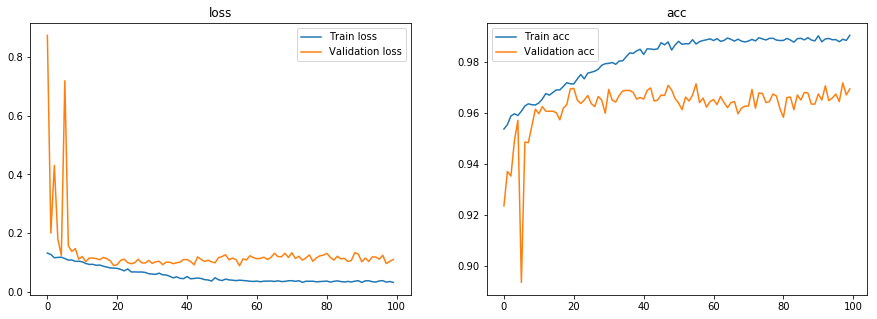

In [51]:
from Evaluation import evaluation, evaluation_f1
evaluation(history)

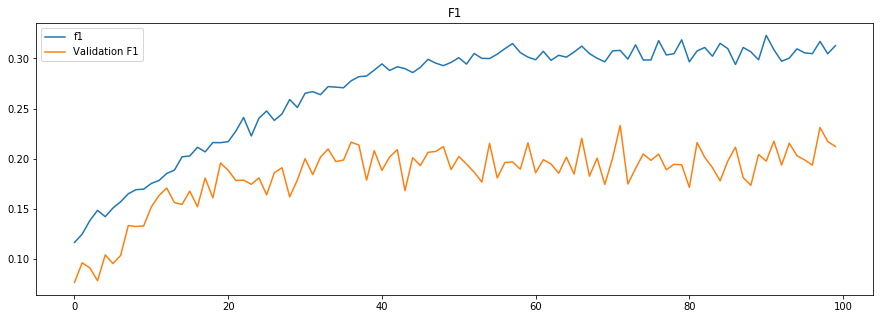

In [52]:
evaluation_f1(history)


### Create submit

In [53]:
submit = pd.read_csv('./input/sample_submission.csv')

In [54]:
%%time
predicted = []
from tqdm import tqdm_notebook
for name in tqdm(submit['Id']):
    path = os.path.join('./input/test/', name)
    image1, image2 = train_datagen.load_image(path, (299,299,3))
    score_predict = model.predict([image1[np.newaxis], image2[np.newaxis]])[0]
    label_predict = np.arange(28)[score_predict>=0.5]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

100%|██████████| 11702/11702 [26:54<00:00,  7.31it/s]

CPU times: user 26min 6s, sys: 2min 7s, total: 28min 13s
Wall time: 26min 54s


In [55]:
submit['Predicted'] = predicted
submit.to_csv('submission.csv', index=False)

### Analysis of submission
Let's look at our results, Which proteins occur most often in our submission?

In [56]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [57]:
def mk_int(s):
    s = s.strip()
    return int(s) if s else 0

In [58]:
submit['target_list'] = submit['Predicted'].map(lambda x: [mk_int(a) for a in str(x).split(' ')])
submit['target_vec'] = submit['target_list'].map(lambda ck: [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(submit['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(v, 'count:', c_val[k] if k in c_val else 0)

Nucleoplasm count: 6649
Nuclear membrane count: 276
Nucleoli count: 831
Nucleoli fibrillar center count: 281
Nuclear speckles count: 335
Nuclear bodies count: 462
Endoplasmic reticulum count: 225
Golgi apparatus count: 610
Peroxisomes count: 7
Endosomes count: 2
Lysosomes count: 1
Intermediate filaments count: 256
Actin filaments count: 144
Focal adhesion sites count: 102
Microtubules count: 314
Microtubule ends count: 0
Cytokinetic bridge count: 96
Mitotic spindle count: 76
Microtubule organizing center count: 159
Centrosome count: 216
Lipid droplets count: 17
Plasma membrane count: 1352
Cell junctions count: 145
Mitochondria count: 764
Aggresome count: 85
Cytosol count: 2796
Cytoplasmic bodies count: 120
Rods & rings count: 0


### Classes distribution:

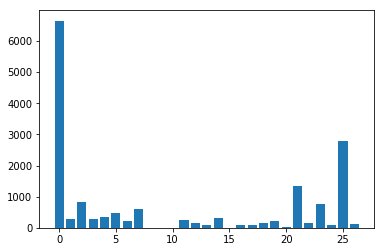

In [59]:
train_sum_vec = np.sum(np.stack(submit['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])
